# Imports

In [1]:
# tab data
import pandas as pd
import numpy as np

# data and prep
from wrangle import wrangle_zillow
from explore import determine_variable_type
from preprocess import scale_data

# data viz
import matplotlib.pyplot as plt

# stats and modeling needs
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

import warnings
warnings.filterwarnings("ignore")

# Prepare Data

In [2]:
# getting data
train, validate, test = wrangle_zillow()

In [3]:
train.head()

,beds,baths,square_feet,tax_value,year_built,tax_amount,fips
9100,4.0,3.0,3190.0,815334.0,1979.0,8698.22,6059.0
1246696,4.0,2.0,1292.0,270136.0,1965.0,3174.66,6059.0
485071,3.0,2.0,1712.0,133228.0,1976.0,1604.10,6111.0
438063,4.0,3.0,2565.0,703483.0,1988.0,8346.21,6037.0
1528007,4.0,2.5,2463.0,647208.0,1966.0,6615.28,6059.0


In [4]:
ex, cat_cols, num_cols = determine_variable_type(train, n_unique=15)

In [5]:
# only use sqaure_feet and tax_amount
num_cols

['square_feet', 'tax_value', 'tax_amount']

In [6]:
# removing the target
num_cols.remove('tax_value')

In [7]:
# xtrain, ytrain
X_train = train[num_cols]
y_train = train[['tax_value']]

# xvalidate, yvalidate
X_validate = validate[num_cols]
y_validate = validate[['tax_value']]

# xtest, ytest
X_test = test[num_cols]
y_test = test[['tax_value']]

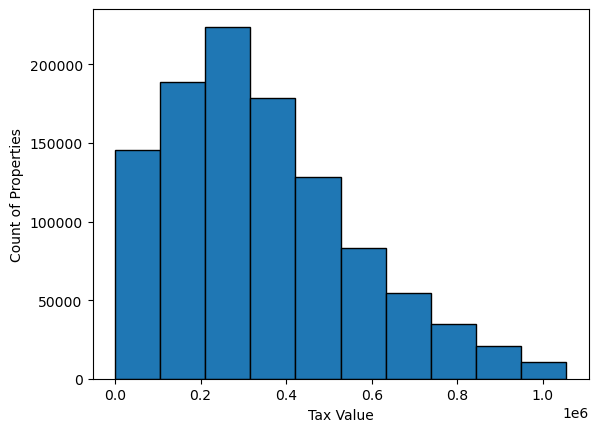

In [8]:
plt.hist(y_train, ec='black')
plt.xlabel('Tax Value')
plt.ylabel('Count of Properties')
plt.show()

# Modeling

In [9]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, num_cols, 'minmax', X_validate=X_validate, X_test=X_test)

## Baseline

In [10]:
# calculating 2 baselines for comparison: 1 for mean and 1 for median
y = 'tax_value'
# checkling the last values for rounding purposes
y_train[y].astype(str).str[-2:].value_counts()

.0    1069570
Name: tax_value, dtype: int64

In [11]:
# first, we will create a column with baseline predictions
y_train['baseline_mean'] = round(y_train[y].mean(), 2)

y_train['baseline_med'] = round(y_train[y].median(), 2)

In [12]:
# we will now add the baseline prediuctions to the validate ds
y_validate['baseline_mean'] = round(y_validate.loc[:,y].mean(), 2)

y_validate['baseline_med'] = round(y_validate.loc[:,y].median(), 2)

In [13]:
# RMSE of mean baseline predictions
rmse_train = mean_squared_error(y_train.loc[:,y], y_train['baseline_mean'], squared=False)
rmse_validate = mean_squared_error(y_validate.loc[:,y], y_validate['baseline_mean'], squared=False)

# checking scores
rmse_train, rmse_validate, rmse_train - rmse_validate

(216142.46611625102, 215982.35433805967, 160.111778191349)

In [14]:
# RMSE of median baseline predictions
rmse_train = mean_squared_error(y_train.loc[:,y], y_train['baseline_med'], squared=False)
rmse_validate = mean_squared_error(y_validate.loc[:,y], y_validate['baseline_med'], squared=False)

# checking scores
rmse_train, rmse_validate, rmse_train - rmse_validate

(219524.97308260584, 219471.81978825212, 53.153294353716774)

#### Takeaways: 
* There is less of a difference between the train and validate ds for the baseline using the median so I will select that although it has a greater rmse

#### Actions:
* Drop the mean_baseline from the train ds
* Plot both the actual and the baseline predications

In [15]:
# dropping the baseline_mean
y_train = y_train.drop(columns='baseline_mean')
y_validate = y_validate.drop(columns='baseline_mean')

In [16]:
# changing the column title
y_train = y_train.rename(columns={'baseline_med': 'baseline_preds'})
y_validate = y_validate.rename(columns={'baseline_med': 'baseline_preds'})

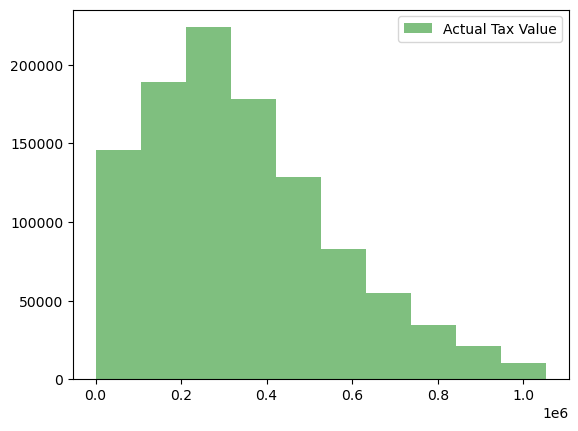

In [17]:
# plt.hist(y_train.baseline_preds, color='black',rwidth=1, label='Predicted Tax Value - Baseline')
plt.hist(y_train.tax_value, color='g', alpha=.5, label='Actual Tax Value')
plt.legend()
plt.show()

## Ordinary Least Squares

In [18]:
def basic_linear_modeling(X_train, y_train, x_validate, y_validate, model):
    '''
    Arguments:
    Actions:
    Returns:
    Modules:
    '''
    # fit the model
    model.fit(X_train, y_train)
   
    # return predictions
    return model.predict(X_train), model.predict(X_validate)
    

In [19]:
basic_linear_modeling(X_train_scaled, y_train['tax_value'], X_validate_scaled, y_validate[['tax_value']], model=LinearRegression())

(array([731160.59368947, 248942.36154109, 119937.53305848, ...,
        804635.23663964, 311248.42570547, 381311.93895204]),
 array([5.22951682e+09, 3.88811405e+09, 5.93806562e+09, ...,
        5.03090452e+09, 1.66528449e+09, 2.93012277e+09]))

In [20]:
y_train['ols_preds'], y_validate['ols_preds'] = basic_linear_modeling(X_train_scaled, y_train[['tax_value']], X_validate_scaled, y_validate[['tax_value']], model=LinearRegression())

In [21]:
# creating the model
lm = LinearRegression(normalize=True)

# fit the model
lm.fit(X_train_scaled, y_train.tax_value)

# make predictions and assign to 
y_train['ols_preds'] = lm.predict(X_train_scaled)

In [22]:
# validate predictions
y_validate['ols_preds'] = lm.predict(X_validate_scaled)

#### Evaluation

In [23]:
rmse_train = mean_squared_error(y_train.tax_value, y_train.ols_preds, squared=False)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.ols_preds, squared=False)

rmse_train, rmse_validate, rmse_train - rmse_validate

(52276.416444688846, 52618.11185381441, -341.6954091255611)

## LassoLars

In [24]:
y_train['lars_alpha1_preds'], y_validate['lars_alpha1_preds'] = basic_linear_modeling(X_train_scaled, y_train[['tax_value']], X_validate_scaled, y_validate[['tax_value']], model=LassoLars(alpha=1))

In [25]:
y_train['lars_alpha_half_preds'], y_validate['lars_alpha_half_preds'] = basic_linear_modeling(X_train_scaled, y_train[['tax_value']], X_validate_scaled, y_validate[['tax_value']], model=LassoLars(alpha=.5))

In [26]:
y_train['lars_alpha_tenth_preds'], y_validate['lars_alpha_tenth_preds'] = basic_linear_modeling(X_train_scaled, y_train[['tax_value']], X_validate_scaled, y_validate[['tax_value']], model=LassoLars(alpha=.1))

## TweedieRegressor (General Linear Model)

In [27]:
y_train['glm_norm_preds'], y_validate['glm_norm_preds'] = basic_linear_modeling(X_train_scaled, y_train[['tax_value']], X_validate_scaled, y_validate[['tax_value']], model=TweedieRegressor(power=0))

In [28]:
y_train['glm_poi_preds'], y_validate['glm_poi_preds'] = basic_linear_modeling(X_train_scaled, y_train[['tax_value']], X_validate_scaled, y_validate[['tax_value']], model=TweedieRegressor(power=1))

## Polynomial Regression

In [29]:
# make the polyni mial features
pf = PolynomialFeatures(degree=2)

# fit_transform
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform for validate
X_validate_degree2 = pf.transform(X_validate_scaled)


In [30]:
X_train_degree2

array([[1.        , 0.8777533 , 0.71061314, 0.77045086, 0.62374303,
        0.50497104],
       [1.        , 0.35517621, 0.25838498, 0.12615014, 0.0917722 ,
        0.0667628 ],
       [1.        , 0.47081498, 0.12979917, 0.22166674, 0.06111139,
        0.01684782],
       ...,
       [1.        , 0.38160793, 0.79665796, 0.14562461, 0.30401099,
        0.63466391],
       [1.        , 0.28854626, 0.32080956, 0.08325894, 0.0925684 ,
        0.10291877],
       [1.        , 0.61371145, 0.37909629, 0.37664175, 0.23265574,
        0.143714  ]])

In [31]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['poly_preds'] = lm2.predict(X_train_degree2)


# predict validate
y_validate['poly_preds'] = lm2.predict(X_validate_degree2)


In [32]:
# basic_linear_modeling(X_train_degree2, y_train.tax_value, X_validate_degree2, y_validate.tax_value, model=LinearRegression())

# Evaluate

In [33]:
y_train.columns

Index(['tax_value', 'baseline_preds', 'ols_preds', 'lars_alpha1_preds',
       'lars_alpha_half_preds', 'lars_alpha_tenth_preds', 'glm_norm_preds',
       'glm_poi_preds', 'poly_preds'],
      dtype='object')

In [34]:
model_rmse = []
target = 'tax_value'
for col in y_train:
    if col in ['glm_poi_preds', 'tax_value']:
        pass
    else:
        rmse_train = mean_squared_error(y_train[target], round(y_train[col], 4), squared=False)
        rmse_validate = mean_squared_error(y_validate[target], round(y_validate[col], 4), squared=False)
        rmse_diff = rmse_train - rmse_validate
        model_rmse.append({
            'Model': col,
            'Train RMSE': rmse_train,
            'Validate RMSE': rmse_validate,
            'RMSE Difference': rmse_diff
        })

In [37]:
train = 1000000
for i in model_rmse:
    if i['Train RMSE'] < train:
        train = i['Train RMSE']

# getting the lowest train RMSE
for i in model_rmse:
    if i['Train RMSE'] == train:
        print(i)

{'Model': 'poly_preds', 'Train RMSE': 52126.06816322001, 'Validate RMSE': 52480.03164808045, 'RMSE Difference': -353.9634848604401}


In [38]:
train = 1000000
for i in model_rmse:
    if abs(i['RMSE Difference']) < train and i['Model'] != 'baseline_preds':
        train = i['RMSE Difference']

# getting the lowest train RMSE
for i in model_rmse:
    if i['RMSE Difference'] == train:
        print(i)

{'Model': 'ols_preds', 'Train RMSE': 52276.416444730115, 'Validate RMSE': 52618.111853771064, 'RMSE Difference': -341.695409040949}


In [40]:
model_rmse

[{'Model': 'baseline_preds',
  'Train RMSE': 219524.97308260584,
  'Validate RMSE': 219471.81978825212,
  'RMSE Difference': 53.153294353716774},
 {'Model': 'ols_preds',
  'Train RMSE': 52276.416444730115,
  'Validate RMSE': 52618.111853771064,
  'RMSE Difference': -341.695409040949},
 {'Model': 'lars_alpha1_preds',
  'Train RMSE': 52290.50050056255,
  'Validate RMSE': 5077368659.17558,
  'RMSE Difference': -5077316368.675079},
 {'Model': 'lars_alpha_half_preds',
  'Train RMSE': 52279.937814388424,
  'Validate RMSE': 5089511213.791596,
  'RMSE Difference': -5089458933.853782},
 {'Model': 'lars_alpha_tenth_preds',
  'Train RMSE': 52276.55730401116,
  'Validate RMSE': 5099225668.93482,
  'RMSE Difference': -5099173392.377516},
 {'Model': 'glm_norm_preds',
  'Train RMSE': 207156.3405131095,
  'Validate RMSE': 222083213.83009896,
  'RMSE Difference': -221876057.48958585},
 {'Model': 'poly_preds',
  'Train RMSE': 52126.06816322001,
  'Validate RMSE': 52480.03164808045,
  'RMSE Difference': 

#### Takeways:
* Absolutely not: Lasso Lars is no, glm is no
* Both OLS and Poly models had lower rmse than the basline. I will go with the polynomial as the best model because it has the lowest rmse and while the difference between train and valisaste rmse is lower for the OLS model, the difference between the two is far less than the diference between their respective scores. 

#### Actions:
* Now I will use a polynomial linear model on the tes data set to see how it performs

## Test

In [42]:
# make the polyni mial features
pf = PolynomialFeatures(degree=2)

# fit_transform
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform for validate
X_test_degree2 = pf.transform(X_test_scaled)


In [30]:
X_train_degree2

array([[1.        , 0.8777533 , 0.71061314, 0.77045086, 0.62374303,
        0.50497104],
       [1.        , 0.35517621, 0.25838498, 0.12615014, 0.0917722 ,
        0.0667628 ],
       [1.        , 0.47081498, 0.12979917, 0.22166674, 0.06111139,
        0.01684782],
       ...,
       [1.        , 0.38160793, 0.79665796, 0.14562461, 0.30401099,
        0.63466391],
       [1.        , 0.28854626, 0.32080956, 0.08325894, 0.0925684 ,
        0.10291877],
       [1.        , 0.61371145, 0.37909629, 0.37664175, 0.23265574,
        0.143714  ]])

In [43]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['poly_preds'] = lm2.predict(X_train_degree2)


# predict validate
y_test['poly_preds'] = lm2.predict(X_test_degree2)


In [46]:
# Getting evaluation metrics
rmse_train = mean_squared_error(y_train[target], y_train['poly_preds'], squared=False)
rmse_test = mean_squared_error(y_test[target], y_test['poly_preds'], squared=False)
rmse_diff = rmse_train - rmse_test
model_rmse.append({
    'Model': col,
    'Train RMSE': rmse_train,
    'Test RMSE': rmse_test,
    'RMSE Difference': rmse_diff
})

In [52]:
model_rmse[-1]

{'Model': 'poly_preds',
 'Train RMSE': 52126.06816321726,
 'Test RMSE': 51949.96644362109,
 'RMSE Difference': 176.10171959616855}

#### Takeaways:
* The poly_preds model performed even better on the test data set

#### Next Steps: 
* Look into other hyperparameters within the polynomial liner regressions
* Look into the poisson distrubution general linear model